# Athena querying

For reference, some high-level instructions can be found in this [link](https://aws.amazon.com/blogs/machine-learning/run-sql-queries-from-your-sagemaker-notebooks-using-amazon-athena/).
 Let's start by accessing the schema related to the quotes and options table.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyathena import connect

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
s3_bucket = "s3://data-from-etl/quotes.parquet/"

conn = connect(s3_staging_dir=s3_bucket,
               region_name='us-west-2')


In [4]:
df = pd.read_sql("""
    SELECT *
      FROM processed.quotes
      LIMIT 8;
    """, conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 17 columns):
intdate         8 non-null int64
ticker          8 non-null object
last_close      8 non-null float64
open            4 non-null float64
max             4 non-null float64
min             4 non-null float64
last            4 non-null float64
qty_bid         8 non-null int64
bid             8 non-null float64
ask             8 non-null float64
qty_ask         8 non-null int64
num_trades      4 non-null float64
qty_total       4 non-null float64
total_volume    4 non-null float64
year            8 non-null int64
month           8 non-null int64
day             8 non-null int64
dtypes: float64(10), int64(6), object(1)
memory usage: 1.1+ KB


In [5]:
df = pd.read_sql("""
    SELECT *
      FROM processed.options
      LIMIT 8;
    """, conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 24 columns):
intdate           8 non-null int64
ticker            8 non-null object
optn_ua           8 non-null object
optn_style        8 non-null object
optn_tp           8 non-null object
optn_expn_days    8 non-null int64
optn_expn_date    8 non-null object
optn_strike       8 non-null float64
optn_bs_delta     8 non-null float64
optn_mkt_bid      1 non-null float64
optn_bs_bid       8 non-null float64
optn_mktbs_bid    8 non-null float64
ua_mkt_bid        8 non-null float64
optn_mkt_ask      0 non-null float64
optn_bs_ask       8 non-null float64
optn_mktbs_ask    8 non-null float64
ua_mkt_ask        8 non-null float64
bid_volimp        0 non-null float64
bid_volcone       8 non-null float64
ask_volimp        0 non-null float64
ask_volcone       8 non-null float64
year              8 non-null int64
month             8 non-null int64
day               8 non-null int64
dtypes: float64(14), int64

Now, let's check the dates presented to query

In [37]:
df = pd.read_sql("""
    SELECT DISTINCT
        year, month, day
      FROM processed.quotes
      ORDER BY year, month, day ASC
      LIMIT 8;
    """, conn)
df

,year,month,day
0,2020,4,1
1,2020,4,2
2,2020,4,3
3,2020,4,6
4,2020,4,7
5,2020,4,9


Something to keep in mind is that Glue only recognizes partitions as strings if you are using the Glue
 crawler to create your table from S3. So, if you want to perform some numerical filter using partitions
 in your query, as below, you should edit the table schema in the AWS Glue console, or you have to create
 and load the data using Boto3.

In [34]:
df = pd.read_sql("""
    SELECT *
      FROM processed.quotes
      WHERE (
          ticker='PETR4'
          AND year=2020
          AND month=4
          AND day>=1
      )
      ORDER BY intdate ASC;
    """, conn)

df.tail()

,intdate,ticker,last_close,open,max,min,last,bid,ask,num_trades,qty_total,total_volume,year,month,day
158,202004091600,PETR4,17.32,17.94,18.69,16.5,16.77,16.77,16.78,1684070,16972000,2.966000e+09,2020,4,9
159,202004091610,PETR4,17.32,17.94,18.69,16.5,16.80,16.80,16.81,1728130,17840000,3.011000e+09,2020,4,9
160,202004091620,PETR4,17.32,17.94,18.69,16.5,16.73,16.72,16.73,1770770,17506000,3.052000e+09,2020,4,9
161,202004091630,PETR4,17.32,17.94,18.69,16.5,16.76,16.76,16.77,1815000,18405000,3.096000e+09,2020,4,9
162,202004091640,PETR4,17.32,17.94,18.69,16.5,16.76,16.76,16.78,1816920,17625000,3.098000e+09,2020,4,9


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 15 columns):
intdate         105 non-null int64
ticker          105 non-null object
last_close      105 non-null float64
open            105 non-null float64
max             105 non-null float64
min             105 non-null float64
last            105 non-null float64
bid             103 non-null float64
ask             103 non-null float64
num_trades      105 non-null int64
qty_total       105 non-null int64
total_volume    105 non-null float64
year            105 non-null int64
month           105 non-null int64
day             105 non-null int64
dtypes: float64(8), int64(6), object(1)
memory usage: 12.4+ KB


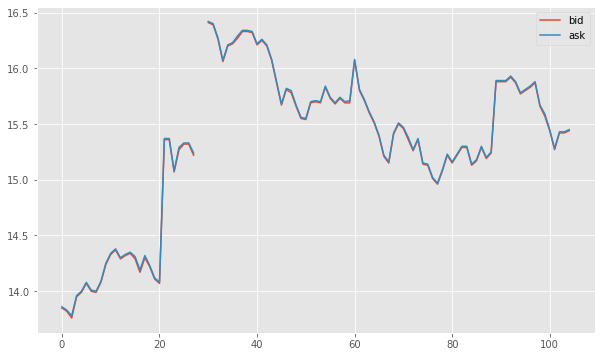

In [22]:
ax = df[['bid', 'ask']].plot();

The data stored has missing values and and has bid/ask prices collected
 throughout each day. Let's plot the spread from two correlated assets.

In [23]:
df = pd.read_sql("""
    SELECT intdate, ticker, bid, ask
      FROM processed.quotes
      WHERE (
          ticker='ITUB4'
          OR ticker='BBDC4'
      )
      ORDER BY intdate ASC;
    """, conn)

df = df.groupby(['intdate', 'ticker']).last().unstack().dropna()
df.index = pd.to_datetime(df.index, format='%Y%m%d%H%M')
df.tail()

bid           ask       
ticker               BBDC4  ITUB4  BBDC4  ITUB4
intdate                                        
2020-04-06 16:00:00  20.91  22.05  20.92  22.06
2020-04-06 16:10:00  20.77  21.98  20.78  21.99
2020-04-06 16:20:00  20.90  22.01  20.92  22.02
2020-04-06 16:30:00  20.94  22.09  20.95  22.11
2020-04-06 16:40:00  20.94  22.11  20.95  22.12

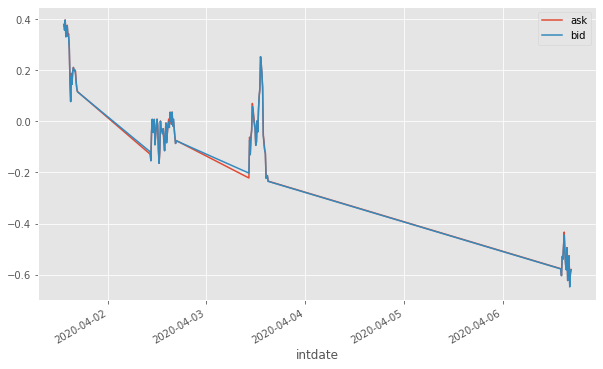

In [24]:
f_mult = 21.52/19.86
ax = ((df[('bid', 'ITUB4')] - df[('bid', 'BBDC4')]*f_mult)).plot(label='ask', legend=True)
((df[('ask', 'ITUB4')] - df[('ask', 'BBDC4')]*f_mult)).plot(label='bid', legend=True, ax=ax);

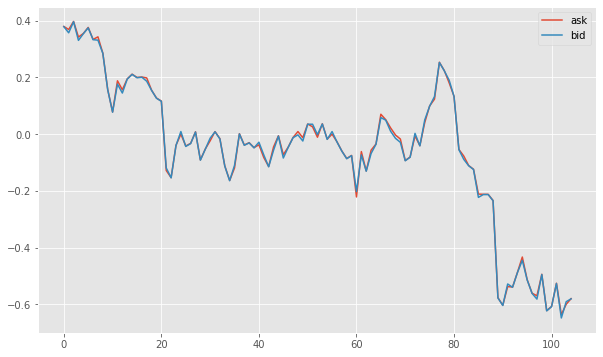

In [25]:
f_mult = 21.52/19.86
ax = ((df[('bid', 'ITUB4')] - df[('bid', 'BBDC4')]*f_mult)).reset_index(drop=True).plot(label='ask', legend=True)
((df[('ask', 'ITUB4')] - df[('ask', 'BBDC4')]*f_mult)).reset_index(drop=True).plot(label='bid', legend=True, ax=ax);

Finally, let's check the options table

In [26]:

df = pd.read_sql("""
    SELECT *
      FROM processed.options
      LIMIT 8;
    """, conn)
df

,intdate,ticker,optn_ua,optn_style,optn_tp,optn_expn_days,optn_expn_date,optn_strike,optn_bs_delta,optn_mkt_bid,...,optn_bs_ask,optn_mktbs_ask,ua_mkt_ask,bid_volimp,bid_volcone,ask_volimp,ask_volcone,year,month,day
0,202004021450,B3SAR342,B3SA3,EURO,PUTT,48,2020-06-15,33.31,0.02,2.71,...,3.01,3.06,35.52,0.6282,0.3619,0.6360,0.5351,2020,4,2
1,202004021450,B3SAR35,B3SA3,EURO,PUTT,48,2020-06-15,34.56,0.02,3.25,...,3.65,3.62,35.52,0.7003,0.3619,0.6947,0.5351,2020,4,2
2,202004021450,B3SAR350,B3SA3,EURO,PUTT,48,2020-06-15,34.06,0.02,3.03,...,3.53,3.39,35.52,0.7134,0.3619,0.7656,0.5351,2020,4,2
3,202004021450,B3SAR352,B3SA3,EURO,PUTT,48,2020-06-15,34.31,0.02,3.14,...,3.47,3.50,35.52,0.6994,0.3619,0.6305,0.5351,2020,4,2
4,202004021450,B3SAR36,B3SA3,EURO,PUTT,48,2020-06-15,35.56,0.02,3.74,...,4.15,4.11,35.52,0.6405,0.3619,0.6990,0.5351,2020,4,2
5,202004021450,B3SAR37,B3SA3,EURO,PUTT,48,2020-06-15,36.56,0.02,4.26,...,4.58,4.63,35.52,0.6866,0.3619,0.6809,0.5351,2020,4,2
6,202004021450,B3SAR38,B3SA3,EURO,PUTT,48,2020-06-15,37.56,0.02,4.82,...,5.02,5.20,35.52,0.6121,0.3619,0.6714,0.5351,2020,4,2
7,202004021450,B3SAR395,B3SA3,EURO,PUTT,48,2020-06-15,38.56,0.02,NaN,...,5.81,5.81,35.52,NaN,0.3619,NaN,0.5351,2020,4,2


In [29]:
df = pd.read_sql("""
    SELECT DISTINCT
        year, month, day
      FROM processed.options
      ORDER BY year, month, day ASC
      LIMIT 8;
    """, conn)
df

,year,month,day
0,2020,4,1
1,2020,4,2
2,2020,4,3
3,2020,4,6
4,2020,4,7
5,2020,4,9
